### Analysing K_f

*import libraries*

In [1]:
import os
import sys
import glob
import sqlite3 as sl

import pandas as pd
import numpy as np
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
%matplotlib inline

import math
import statistics
import scipy.stats


**import data**

In [2]:
path = './data/P00' 

In [3]:
# loop dfs from *.csv
list_of_kagers = []
list_of_kagers = [pd.read_csv(filename) for filename in glob.glob(path + '*_K_f.csv')]

In [4]:
# xlsx = pd.ExcelFile('./data/Clinical_001_003.xlsx')
clinical = pd.read_excel('./data/Clinical_001_006.xlsx',header=1)

In [5]:
clinical

,Unnamed: 0,age (years),gender,handedness,date of event,nature of stroke,side of stroke,involved UL,first/recurrent stroke,Oxford scale,...,UL fugl meyer.1,SWMFT- time (seconds).1,SWMFT- FAS.1,ARAT .1,grip- affected (kg/f).1,grip- unaffected (kg/f).1,MAS- shoulder.1,MAS- elbow.1,MAS- wrist.1,MAS- fingers.1
0,CHI_001,75.0,M,R,2020-05-01,infarct,L,R,first,Lacunar,...,17/66,76.010,1.630,4/57,5.57,30.57,0,1,1+,1+
1,CHI_002,52.0,M,R,2012-07-01,haemorrhage,L,R,first,BG,...,33/66,61.610,2.130,12/57,7.63,26.87,1,1+,1+,1
2,CHI_003,54.0,M,R,2021-03-01,infarct,L,R,first,lacunar,...,43/66,34.770,2.500,21/57,9.77,24.07,1,1+,1+,1+
3,CHI_004,NaN,NaN,NaN,NaT,NaN,L,NaN,NaN,NaN,...,338/66,61.570,1.875,6/57,5.53,23.87,0,1,1,2
4,CHI_006,NaN,NaN,NaN,NaT,NaN,R,NaN,NaN,NaN,...,50/66,3.135,3.250,34/57,9.50,27.27,0,1,0,0


In [6]:
clinical.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 30 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Unnamed: 0                 5 non-null      object        
 1   age (years)                3 non-null      float64       
 2   gender                     3 non-null      object        
 3   handedness                 3 non-null      object        
 4   date of event              3 non-null      datetime64[ns]
 5   nature of stroke           3 non-null      object        
 6   side of stroke             5 non-null      object        
 7   involved UL                3 non-null      object        
 8   first/recurrent stroke     3 non-null      object        
 9   Oxford scale               3 non-null      object        
 10  UL fugl meyer              5 non-null      object        
 11  SWMFT- time (seconds)      5 non-null      float64       
 12  SWMFT- FAS  

**cleaning clinical df**

In [7]:
clinical.columns = clinical.columns.str.replace(' ','')
clinical.columns = clinical.columns.str.replace(r'\(.*\) ?','')
clinical['ULfuglmeyer'] = clinical['ULfuglmeyer'].str.replace('/',' ').str[:2].astype(int)
clinical['ULfuglmeyer.1'] = clinical['ULfuglmeyer.1'].str.replace('/',' ').str[:2].astype(int)
clinical['ARAT'] = clinical['ARAT'].str.replace('/',' ').str[:2].astype(int)
clinical['ARAT.1'] = clinical['ARAT.1'].str.replace('/',' ').str[:2].astype(int) 

<ipython-input-7-91a83dbea998>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  clinical.columns = clinical.columns.str.replace(r'\(.*\) ?','')


#### initial K_f vs change in K_f

In [8]:
player_nr = []
initial_K_f = []
change_K_f = []
for nr, kager in enumerate(list_of_kagers):
    kager.rename(columns = {'0' : 'K_f',
                           'Unnamed: 0' : 'session_nr'}, inplace=True)
    K_f_diff = kager['K_f'].iloc[-1] - kager['K_f'].iloc[1]
    player_nr.append(nr+1)
    initial_K_f.append(kager['K_f'].iloc[1])
    change_K_f.append(K_f_diff)

In [9]:
K_f = {'player_nr' : player_nr,
      'initial_K_f' : initial_K_f,
      'change_K_f' : change_K_f}
K_f = pd.DataFrame(K_f) 
K_f

,player_nr,initial_K_f,change_K_f
0,1,786.087373,-756.373977
1,2,411.861892,-417.190364
2,3,618.042114,-657.498611
3,4,160.280250,-174.480320
4,5,-58.106837,284.547448
5,6,136.548250,-240.534686


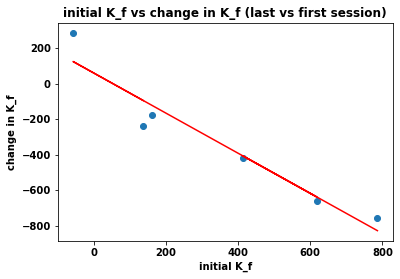

In [10]:
plt.scatter(K_f['initial_K_f'],K_f['change_K_f'],marker='o')

# plot trendline (linear fitting)
z = np.polyfit(K_f['initial_K_f'],K_f['change_K_f'], 1)
p = np.poly1d(z)
plt.plot(K_f['initial_K_f'],p(K_f['initial_K_f']),'r-')

plt.xlabel('initial K_f')
plt.ylabel('change in K_f')
plt.title('initial K_f vs change in K_f (last vs first session)',fontsize=12)
plt.show();

#### correlation K_f vs clinical assessment

In [11]:
clinical.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 30 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Unnamed:0              5 non-null      object        
 1   age                    3 non-null      float64       
 2   gender                 3 non-null      object        
 3   handedness             3 non-null      object        
 4   dateofevent            3 non-null      datetime64[ns]
 5   natureofstroke         3 non-null      object        
 6   sideofstroke           5 non-null      object        
 7   involvedUL             3 non-null      object        
 8   first/recurrentstroke  3 non-null      object        
 9   Oxfordscale            3 non-null      object        
 10  ULfuglmeyer            5 non-null      int32         
 11  SWMFT-time             5 non-null      float64       
 12  SWMFT-FAS              5 non-null      float64       
 13  ARAT     

In [12]:
clinical['diff_fuglmeyer'] = clinical['ULfuglmeyer.1'] - clinical['ULfuglmeyer']
clinical['diff_SWMFT-time'] = clinical['SWMFT-time.1'] - clinical['SWMFT-time']
clinical['diff_SWMFT-FAS'] = clinical['SWMFT-FAS.1'] - clinical['SWMFT-FAS']
clinical['diff_ARAT'] = clinical['ARAT.1'] - clinical['ARAT']
clinical['diff_grip-affected'] = clinical['grip-affected.1'] - clinical['grip-affected']
clinical['diff_grip-unaffected'] = clinical['grip-unaffected.1'] - clinical['grip-unaffected']


In [13]:
def connectpoints(x,y,p1,p2):
    x1, x2 = x[p1], x[p2]
    y1, y2 = y[p1], y[p2]
    plt.plot([x1,x2],[y1,y2],'r-')


##### Upper Extremity Fugh Meyer 

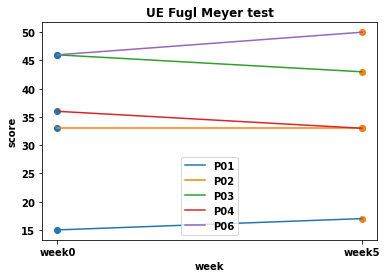

In [14]:
x = ['week0','week5']
y = [clinical['ULfuglmeyer'],clinical['ULfuglmeyer.1']]
# plot UE Fugh Meyer 
for xe, ye in zip(x, y):
    plt.scatter([xe] * len(ye), ye)

lineObjects = plt.plot(x, y)
plt.legend(iter(lineObjects), ('P01', 'P02', 'P03', 'P04', 'P06'))
# connectpoints(x,y,0,1)
plt.title('UE Fugl Meyer test')
plt.xlabel('week')
plt.ylabel('score')
plt.show();

##### streamlined Wolf Motor Function Test - time

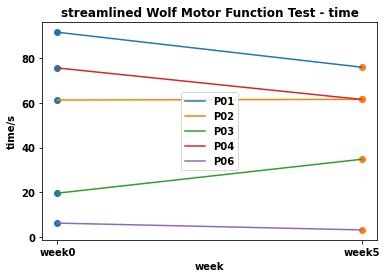

In [15]:
y = [clinical['SWMFT-time'],clinical['SWMFT-time.1']]
# plot SWMFT-time 
for xe, ye in zip(x, y):
    plt.scatter([xe] * len(ye), ye)
lineObjects = plt.plot(x, y)
plt.legend(iter(lineObjects), ('P01', 'P02', 'P03', 'P04', 'P06'))
plt.title('streamlined Wolf Motor Function Test - time')
plt.xlabel('week')
plt.ylabel('time/s')
plt.show();

##### streamlined Wolf Motor Function Test - Functional Ability Scale

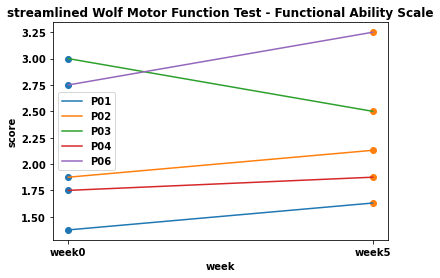

In [16]:
y = [clinical['SWMFT-FAS'],clinical['SWMFT-FAS.1']]
# plot WMFT–Functional Ability Scale 
for xe, ye in zip(x, y):
    plt.scatter([xe] * len(ye), ye)
lineObjects = plt.plot(x, y)
plt.legend(iter(lineObjects), ('P01', 'P02', 'P03', 'P04', 'P06'))
plt.title('streamlined Wolf Motor Function Test - Functional Ability Scale')
plt.xlabel('week')
plt.ylabel('score')
plt.show();

##### Action Research Arm Test
<br> ARAT score range, 0-57; Low ability=scores 0-19; Moderate ability=scores 20-38; High ability=scores 39-57;

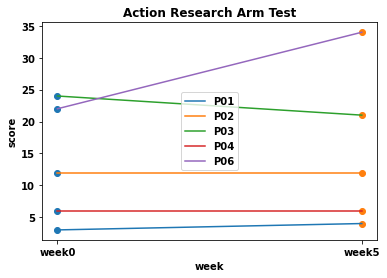

In [17]:
y = [clinical['ARAT'],clinical['ARAT.1']]
# plot Action Research Arm Test
for xe, ye in zip(x, y):
    plt.scatter([xe] * len(ye), ye)
lineObjects = plt.plot(x, y)
plt.legend(iter(lineObjects), ('P01', 'P02', 'P03', 'P04', 'P06'))
plt.title('Action Research Arm Test')
plt.xlabel('week')
plt.ylabel('score')
plt.show();

##### Grip strength 
**affected side**

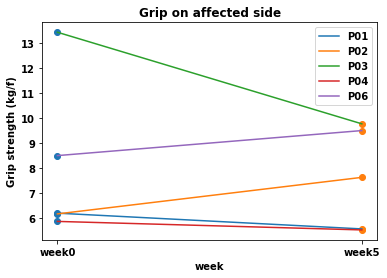

In [18]:
x = ['week0','week5']
y = [clinical['grip-affected'],clinical['grip-affected.1']]
# plot grip-affected
for xe, ye in zip(x, y):
    plt.scatter([xe] * len(ye), ye)

lineObjects = plt.plot(x, y)
plt.legend(iter(lineObjects), ('P01', 'P02', 'P03', 'P04', 'P06'))

plt.title('Grip on affected side')
plt.xlabel('week')
plt.ylabel('Grip strength (kg/f)')
plt.show();

**unaffected side**

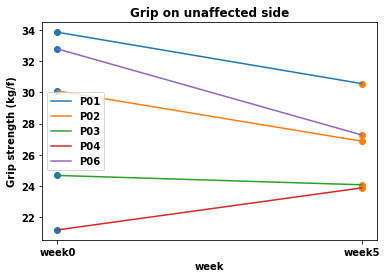

In [19]:
x = ['week0','week5']
y = [clinical['grip-unaffected'],clinical['grip-unaffected.1']]
# plot grip-affected
for xe, ye in zip(x, y):
    plt.scatter([xe] * len(ye), ye)

lineObjects = plt.plot(x, y)
plt.legend(iter(lineObjects), ('P01', 'P02', 'P03', 'P04', 'P06'))

plt.title('Grip on unaffected side')
plt.xlabel('week')
plt.ylabel('Grip strength (kg/f)')
plt.show();

##### Motor Assessment Scale (MAS)
<br> modified-modified Ashworth scale (m-MAS)
<br> **shoulder**
<br> score 0 signifies normal muscle tone, score 1 a slight increase in muscle tone with a slight catch when the limb is moved in flexion and extension, score 1+ a slight increase in muscle tone with minimal resistance at the end of movement, score 2 a more marked increase in muscle tone through the entire 

In [20]:
MAS = ['shoulder','elbow','wrist','fingers']
MAS_col = ['MAS-' + name for name in MAS] + ['MAS-' + name + '.1' for name in MAS]

In [21]:
# convert MAS->m-MAS
# 0 -> 0
# 1 -> 1
# 1+ -> 2
# 2 -> 3
# 3 -> 4
# 4 -> 5
def convert_MAS(row):
    for name in MAS_col:
        if row[name] == '1+':
            row[name] = '2'
        elif row[name] == '2':
            row[name] = '3'
        elif row[name] == '3':
            row[name] = '4'
        elif row[name] == '4':
            row[name] = '5'
        row[name] = pd.to_numeric(row[name])
    return row

In [22]:
clinical = clinical.apply(convert_MAS, axis=1)

**shoulder**

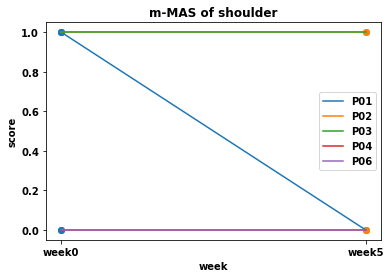

In [23]:
x = ['week0','week5']
y = [clinical['MAS-shoulder'],clinical['MAS-shoulder.1']]
# plot MAS-shoulder
for xe, ye in zip(x, y):
    plt.scatter([xe] * len(ye), ye)

lineObjects = plt.plot(x, y)
plt.legend(iter(lineObjects), ('P01', 'P02', 'P03', 'P04', 'P06'))

plt.title('m-MAS of shoulder')
plt.xlabel('week')
plt.ylabel('score')
plt.show();

**elbow**

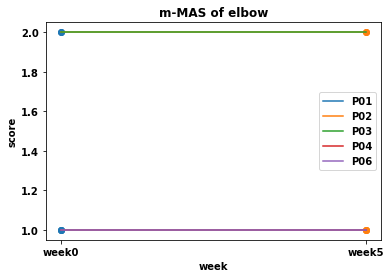

In [24]:
x = ['week0','week5']
y = [clinical['MAS-elbow'],clinical['MAS-elbow.1']]
# plot MAS-elbow
for xe, ye in zip(x, y):
    plt.scatter([xe] * len(ye), ye)

lineObjects = plt.plot(x, y)
plt.legend(iter(lineObjects), ('P01', 'P02', 'P03', 'P04', 'P06'))

plt.title('m-MAS of elbow')
plt.xlabel('week')
plt.ylabel('score')
plt.show();

**wrist**

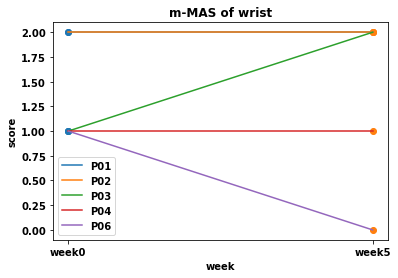

In [25]:
x = ['week0','week5']
y = [clinical['MAS-wrist'],clinical['MAS-wrist.1']]
# plot MAS-wrist
for xe, ye in zip(x, y):
    plt.scatter([xe] * len(ye), ye)

lineObjects = plt.plot(x, y)
plt.legend(iter(lineObjects), ('P01', 'P02', 'P03', 'P04', 'P06'))

plt.title('m-MAS of wrist')
plt.xlabel('week')
plt.ylabel('score')
plt.show();

**fingers**

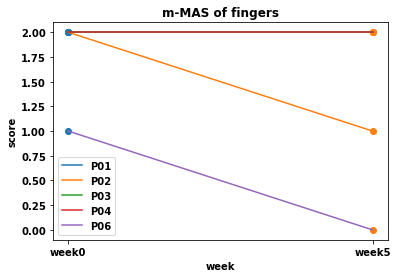

In [26]:
x = ['week0','week5']
y = [clinical['MAS-fingers'],clinical['MAS-fingers.1']]
# plot MAS-fingers
for xe, ye in zip(x, y):
    plt.scatter([xe] * len(ye), ye)

lineObjects = plt.plot(x, y)
plt.legend(iter(lineObjects), ('P01', 'P02', 'P03', 'P04', 'P06'))

plt.title('m-MAS of fingers')
plt.xlabel('week')
plt.ylabel('score')
plt.show();

In [27]:
clinical['diff_MAS-shoulder'] = clinical['MAS-shoulder.1'] - clinical['MAS-shoulder']
clinical['diff_MAS-elbow'] = clinical['MAS-elbow.1'] - clinical['MAS-elbow']
clinical['diff_MAS-wrist'] = clinical['MAS-wrist.1'] - clinical['MAS-wrist']
clinical['diff_MAS-fingers'] = clinical['MAS-fingers.1'] - clinical['MAS-fingers']